Import all the libraries that we need

In [1]:
#!pip install bs4
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#import urllib.request
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium # map rendering library

Import the page to BeautifulSoup

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')
soup = soup.find_all("table")

Find the data that we want and save in different lists

In [3]:
Postal_code = []
Neighborhood = []
Borough = []

for table in soup:
    rows = table.find_all('tr')
   
    for row in rows:
        cells = row.find_all('td')
       
        if len(cells) > 2:
            PC = cells[0]
            Postal_code.append(PC.text)
            
            Neigh = cells[2]
            Neighborhood.append(Neigh.text.strip())
            
            Bor = cells[1]
            Borough.append(Bor.text.strip())

Create the DataFrame and eliminate the wrong data

In [4]:
df = pd.DataFrame([Postal_code,Borough,Neighborhood])
df = df.T
df.columns = ["Postal_code","Borough","Neighborhood",]
df = df.drop([184,183,182,181,180])
df.tail(10)

,Postal_code,Borough,Neighborhood
170,M9Y\n,Not assigned,Not assigned
171,M1Z\n,Not assigned,Not assigned
172,M2Z\n,Not assigned,Not assigned
173,M3Z\n,Not assigned,Not assigned
174,M4Z\n,Not assigned,Not assigned
175,M5Z\n,Not assigned,Not assigned
176,M6Z\n,Not assigned,Not assigned
177,M7Z\n,Not assigned,Not assigned
178,M8Z\n,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."
179,M9Z\n,Not assigned,Not assigned


Drop the "Not assigned" data from Borough column

In [5]:
a = df.shape
c = []
for i in range (a[0]):
    b = df.iloc[i,1]
    if (b=='Not assigned'):
        c.append(i)

df = df.drop(c)

Check the "Not assigned" data in Neighborhood, and change the Postal_code names because they have an extra "\n"

In [6]:
a = df.shape
c = []
n = []
for i in range (a[0]):
    b = df.iloc[i,2]
    n.append(i)
    d = df.iloc[i,0]
    df.iloc[i,0] = d[:-1]
    if (b=='Not assigned'):
        c.append(i)                                              #There is not values in c
df = df.sort_values(['Postal_code'], ascending=1)        
df.index = n
df

,Postal_code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [7]:
df.shape

(103, 3)

In [8]:
df2 = pd.read_csv("Geospatial_Coordinates.csv")
df2 = df2.sort_values(['Postal Code'], ascending=1)
df = pd.concat([df, df2], axis=1, sort=False)
del df['Postal Code']
df

,Postal_code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


We define and create the map that is centered in Toronto

In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


We insert circle marker for each postal code, we put each Borough with a different color

In [11]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    if borough=="Scarborough":
        Col = "blue"
    elif borough=="York":
        Col = "orange"
    elif borough=="North York":
        Col = "red"
    elif borough=="East York":
        Col = "green"
    elif borough=="East Toronto":
        Col = "yellow"
    elif borough=="Central Toronto":
        Col = "brown"
    elif borough=="Downtown Toronto":
        Col = "violet"
    elif borough=="West Toronto":
        Col = "black"
    elif borough=="Mississauga":
        Col = "olive"
    elif borough=="Etobicoke":
        Col = "white"
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=Col,
        fill=True,
        fill_color=Col,
        fill_opacity=0.1,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

Populating the interactive namespace from numpy and matplotlib


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


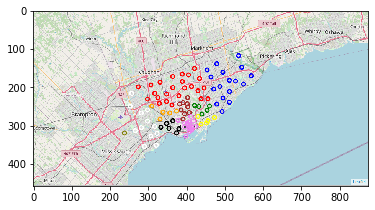

In [17]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('Toronto.PNG')
imgplot = plt.imshow(img)
plt.show()